<a href="https://colab.research.google.com/github/AkbarResdika/Tugas-Akhir_LightGCN-Sistem-Rekomendasi-Film/blob/main/Modifikasi_Tugas_Akhir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pip Recommenders

In [ ]:
!pip install recommenders

In [ ]:
from recommenders.models.deeprec.deeprec_utils import prepare_hparams

#Data Understanding

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

In [ ]:
DEFAULT_USER_COL = "userId"
DEFAULT_ITEM_COL = "movieId"
DEFAULT_RATING_COL = "rating"
DEFAULT_TIMESTAMP_COL = "timestamp"
DEFAULT_PREDICTION_COL = "prediction"
DEFAULT_GENRE_COL = "genreId"

DEFAULT_HEADER = (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_GENRE_COL,
    DEFAULT_TIMESTAMP_COL,
)

COL_DICT = {
    "col_user": DEFAULT_USER_COL,
    "col_item": DEFAULT_ITEM_COL,
    "col_rating": DEFAULT_RATING_COL,
    "col_genre": DEFAULT_GENRE_COL,
    "col_prediction": DEFAULT_PREDICTION_COL,
}

DEFAULT_K = 50
DEFAULT_THRESHOLD = 10

# Other
SEED = 42


##Import Data

In [ ]:
ratings = pd.read_csv('/content/ratings.csv')
movies = pd.read_csv('/content/movies.csv')

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
movie_ratings = ratings.merge(movies, on='movieId', how='inner')
movie_ratings.head(5)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,964982931,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [ ]:
movie_ratings = movie_ratings.drop(columns=['title'])

In [ ]:
movie_genres = movie_ratings.copy()
movie_genres['genres'] = movie_genres['genres'].str.split('|')
movie_genres_exploded = movie_genres.explode('genres')

print("DataFrame setelah explode genres:")
display(movie_genres_exploded.head())

unique_genres = movie_genres_exploded['genres'].unique()

# Menampilkan daftar genre unik
print("\nDaftar genre unik:")
print(unique_genres)

genre_to_id = {genre: id for id, genre in enumerate(unique_genres)}

print("\nPemetaan Genre ke ID:")
print(genre_to_id)

# Membuat DataFrame dari pemetaan untuk penggabungan
genre_id_map_df = pd.DataFrame(list(genre_to_id.items()), columns=['genres', 'genreId'])


movie_ratings_with_genre_id = pd.merge(
    movie_genres_exploded,
    genre_id_map_df,
    on='genres',
    how='left' #
)

# Menampilkan beberapa baris pertama dari DataFrame akhir
print("\nDataFrame akhir dengan genreId:")
display(movie_ratings_with_genre_id.head())

DataFrame setelah explode genres:


,userId,movieId,rating,timestamp,genres
0,1,1,4.0,964982703,Adventure
0,1,1,4.0,964982703,Animation
0,1,1,4.0,964982703,Children
0,1,1,4.0,964982703,Comedy
0,1,1,4.0,964982703,Fantasy



Daftar genre unik:
['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Action'
 'Crime' 'Thriller' 'Mystery' 'Horror' 'Drama' 'War' 'Western' 'Sci-Fi'
 'Musical' 'Film-Noir' 'IMAX' 'Documentary' '(no genres listed)']

Pemetaan Genre ke ID:
{'Adventure': 0, 'Animation': 1, 'Children': 2, 'Comedy': 3, 'Fantasy': 4, 'Romance': 5, 'Action': 6, 'Crime': 7, 'Thriller': 8, 'Mystery': 9, 'Horror': 10, 'Drama': 11, 'War': 12, 'Western': 13, 'Sci-Fi': 14, 'Musical': 15, 'Film-Noir': 16, 'IMAX': 17, 'Documentary': 18, '(no genres listed)': 19}

DataFrame akhir dengan genreId:


,userId,movieId,rating,timestamp,genres,genreId
0,1,1,4.0,964982703,Adventure,0
1,1,1,4.0,964982703,Animation,1
2,1,1,4.0,964982703,Children,2
3,1,1,4.0,964982703,Comedy,3
4,1,1,4.0,964982703,Fantasy,4


In [ ]:
movie_ratings = movie_ratings_with_genre_id
movie_ratings = movie_ratings.drop(columns=['genres'])
movie_ratings.head()

,userId,movieId,rating,timestamp,genreId
0,1,1,4.0,964982703,0
1,1,1,4.0,964982703,1
2,1,1,4.0,964982703,2
3,1,1,4.0,964982703,3
4,1,1,4.0,964982703,4


In [ ]:
COL_USER = "userId"
COL_ITEM = "movieId"
COL_RATING = "rating"
COL_PREDICTION = "prediction"
COL_GENRE = "genreId"
COL_TIMESTAMP = "timestamp"

In [ ]:
data = movie_ratings.rename(
    columns={
        "userId": COL_USER,
        "movieId": COL_ITEM,
        "rating": COL_RATING,
        "timestamp": COL_TIMESTAMP,
        "genreId": COL_GENRE,
        "prediction": COL_PREDICTION,
    }
)

data.head()

,userId,movieId,rating,timestamp,genreId
0,1,1,4.0,964982703,0
1,1,1,4.0,964982703,1
2,1,1,4.0,964982703,2
3,1,1,4.0,964982703,3
4,1,1,4.0,964982703,4


In [ ]:
data.describe()

,userId,movieId,rating,timestamp,genreId
count,274480.000000,274480.000000,274480.000000,2.744800e+05,274480.000000
mean,324.707607,20302.543398,3.517797,1.213584e+09,6.885697
std,182.550241,35369.990843,1.034705,2.167614e+08,4.365163
min,1.000000,1.000000,0.500000,8.281246e+08,0.000000
25%,177.000000,1198.000000,3.000000,1.030475e+09,3.000000
50%,323.000000,3037.000000,3.500000,1.196131e+09,6.000000
75%,477.000000,8961.000000,4.000000,1.442154e+09,11.000000
max,610.000000,193609.000000,5.000000,1.537799e+09,19.000000


<ipython-input-37-3377034991>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=data, palette="viridis")


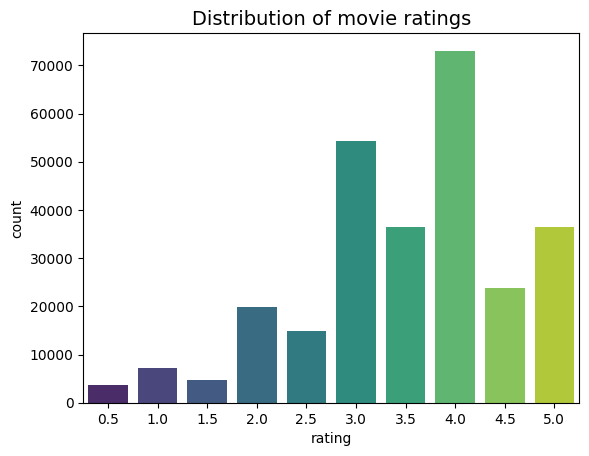

In [ ]:
sns.countplot(x="rating", data=data, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [ ]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [ ]:
# Menghitung total interaksi antar user dan item
total_interactions = data.shape[0]

# Menghitung total jumlah pengguna dan item
num_users = data[COL_USER].nunique()
num_items = data[COL_ITEM].nunique()
num_genres = data[COL_GENRE].nunique()

# Menghitung densitas interaksi
interaction_density = (total_interactions / (num_users * num_items)) * 100
interaction_density_genre = (total_interactions / (num_items * num_genres)) * 100

print(
    f"Total Interactions: {total_interactions}",
    f"Number of Users: {num_users}",
    f"Number of Items: {num_items}",
    f"Number of Genres: {num_genres}",
    sep="\n"
)

Total Interactions: 274480
Number of Users: 610
Number of Items: 9724
Number of Genres: 20


#Data Preparation

##Data Transformation

In [ ]:
from datetime import datetime, timedelta

data[COL_TIMESTAMP]= data.apply(
    lambda x: datetime.strftime(datetime(1970, 1, 1, 0, 0, 0) + timedelta(seconds=x[COL_TIMESTAMP].item()), "%Y-%m-%d %H:%M:%S"),
    axis=1
)
data.head()

,userId,movieId,rating,timestamp,genreId
0,1,1,4.0,2000-07-30 18:45:03,0
1,1,1,4.0,2000-07-30 18:45:03,1
2,1,1,4.0,2000-07-30 18:45:03,2
3,1,1,4.0,2000-07-30 18:45:03,3
4,1,1,4.0,2000-07-30 18:45:03,4


#Train Test Split Data

In [ ]:
# top k items to recommend
TOP_K = 50

# Model parameters
EPOCHS = 100
BATCH_SIZE = 1024

SEED = 42

yaml3_file = "/content/lightgcn3.yaml"
yaml4_file = "/content/lightgcn4.yaml"
yaml5_file = "/content/lightgcn5.yaml"
user_file = "/content/user_embeddings.csv"
item_file = "/content/item_embeddings.csv"


In [ ]:
import numpy as np
import pandas as pd

def process_split_ratio(ratio):
    """.Menghasilkan daftar rasio pembagian.

    Argumen:
        ratio (float atau list): Sebuah angka desimal (float) yang menunjukkan rasio pembagian atau sebuah daftar angka desimal (list) yang menunjukkan rasio pembagian
                                 (jika pembagian dilakukan dalam beberapa bagian atau multi-split).

    Mengembalikan:
        tuple:
        - bool: Sebuah variabel boolean `multi` yang menunjukkan apakah pembagian dilakukan
          dalam beberapa bagian (multi-split) atau satu bagian (single-split).
        - list: Daftar rasio pembagian yang telah dinormalisasi.
    """
    #ketika data pembagian hanya data latih dan uji (float)
    if isinstance(ratio, float):
        if ratio <= 0 or ratio >= 1:
            raise ValueError("Split ratio has to be between 0 and 1")

        multi = False
    #ketika data bentuk list
    elif isinstance(ratio, list):
        if any([x <= 0 for x in ratio]):
            raise ValueError(
                "All split ratios in the ratio list should be larger than 0."
            )

        # normalize split ratios if they are not summed to 1
        if math.fsum(ratio) != 1.0:
            ratio = [x / math.fsum(ratio) for x in ratio]

        multi = True
    else:
        raise TypeError("Split ratio should be either float or a list of floats.")

    return multi, ratio

def _get_column_name(name, col_user, col_item):
    if name == "user":
        return col_user
    elif name == "item":
        return col_item
    else:
        raise ValueError("name should be either 'user' or 'item'.")

def min_rating_filter_pandas(
    data,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
):
    """Memfilter DataFrame rating untuk setiap pengguna dengan jumlah rating minimum.

      Memfilter data frame rating dengan jumlah rating minimum untuk pengguna/item biasanya berguna untuk menghasilkan data frame baru dengan pengguna/item hangat. Kehangatan didefinisikan oleh
      argumen min_rating. Sebagai contoh, seorang pengguna disebut hangat jika dia telah memberikan rating pada setidaknya 4 item.

      Argumen:
          data (pandas.DataFrame): DataFrame dari pasangan user-item. Kolom untuk pengguna dan item harus ada dalam DataFrame, sedangkan kolom lain seperti rating bersifat opsional.
          min_rating (int): Jumlah minimum rating untuk pengguna atau item.
          filter_by (str): Pilihan "user" atau "item", tergantung pada mana yang akan difilter berdasarkan min_rating.
          col_user (str): Nama kolom untuk ID pengguna.
          col_item (str): Nama kolom untuk ID item.

      Mengembalikan:
          pandas.DataFrame: DataFrame dengan setidaknya kolom pengguna dan item yang telah difilter berdasarkan spesifikasi yang diberikan.
    """
    split_by_column = _get_column_name(filter_by, col_user, col_item)

    if min_rating < 1:
        raise ValueError("min_rating should be integer and larger than or equal to 1.")

    return data.groupby(split_by_column).filter(lambda x: len(x) >= min_rating)

def _do_stratification(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    is_random=True,
    seed=42,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_timestamp=DEFAULT_TIMESTAMP_COL,
):
    # A few preliminary checks.
    if not (filter_by == "user" or filter_by == "item"):
        raise ValueError("filter_by should be either 'user' or 'item'.")

    if min_rating < 1:
        raise ValueError("min_rating should be integer and larger than or equal to 1.")

    if col_user not in data.columns:
        raise ValueError("Schema of data not valid. Missing User Col")

    if col_item not in data.columns:
        raise ValueError("Schema of data not valid. Missing Item Col")

    if not is_random:
        if col_timestamp not in data.columns:
            raise ValueError("Schema of data not valid. Missing Timestamp Col")

    multi_split, ratio = process_split_ratio(ratio)

    split_by_column = col_user if filter_by == "user" else col_item

    ratio = ratio if multi_split else [ratio, 1 - ratio]

    if min_rating > 1:
        data = min_rating_filter_pandas(
            data,
            min_rating=min_rating,
            filter_by=filter_by,
            col_user=col_user,
            col_item=col_item,
        )

    if is_random:
        np.random.seed(seed)
        data["random"] = np.random.rand(data.shape[0])
        order_by = "random"
    else:
        order_by = col_timestamp

    data = data.sort_values([split_by_column, order_by])

    groups = data.groupby(split_by_column)

    data["count"] = groups[split_by_column].transform("count")
    data["rank"] = groups.cumcount() + 1

    if is_random:
        data = data.drop("random", axis=1)

    splits = []
    prev_threshold = None
    for threshold in np.cumsum(ratio):
        condition = data["rank"] <= round(threshold * data["count"])
        if prev_threshold is not None:
            condition &= data["rank"] > round(prev_threshold * data["count"])
        splits.append(data[condition].drop(["rank", "count"], axis=1))
        prev_threshold = threshold

    return splits

def python_stratified_split(
    data,
    ratio=0.75,
    min_rating=1,
    filter_by="user",
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    seed=42,
):
    """"Pembagi stratifikasi Pandas.

        Untuk setiap pengguna/item, fungsi split mengambil proporsi rating yang ditentukan oleh rasio pembagian (split ratio). Pembagian dilakukan secara stratifikasi.

        Argumen:
            data (pandas.DataFrame): DataFrame Pandas yang akan dibagi.
            ratio (float atau list): Rasio untuk membagi data. Jika merupakan angka float tunggal, data dibagi menjadi dua bagian dan argumen rasio menunjukkan proporsi data pelatihan;
                                     jika merupakan daftar angka float, pembagi membagi data menjadi beberapa bagian yang sesuai dengan rasio pembagian. Jika daftar diberikan dan
                                     rasio tidak dijumlahkan menjadi 1, rasio akan dinormalisasi.
            seed (int): Seed.
            min_rating (int): Jumlah minimum rating untuk pengguna atau item.
            filter_by (str): Pilihan "user" atau "item", tergantung pada mana yang akan difilter
                berdasarkan min_rating.
            col_user (str): Nama kolom untuk ID pengguna.
            col_item (str): Nama kolom untuk ID item.

        Mengembalikan:
            list: Pembagian data input sebagai pandas.DataFrame.
    """
    return _do_stratification(
        data,
        ratio=ratio,
        min_rating=min_rating,
        filter_by=filter_by,
        col_user=col_user,
        col_item=col_item,
        is_random=True,
        seed=seed,
    )

In [ ]:
train, test = python_stratified_split(data, ratio=0.75)

#Model LightGCN

##Proses Data

##ImplicitCF

In [ ]:
# Licensed under the MIT License.

import random
import numpy as np
import pandas as pd
import scipy.sparse as sp
from scipy import sparse
import math


class ImplicitCF(object):
    """Kelas pemrosesan data untuk model GCN yang menggunakan umpan balik implisit.

      Menginisialisasi set pelatihan dan pengujian, membuat normalized adjacency matrix,
      dan mengambil sampel data untuk epoch pelatihan.

    """

    def __init__(
        self,
        train,
        test=None,
        adj_dir=None,
        col_user=DEFAULT_USER_COL,
        col_item=DEFAULT_ITEM_COL,
        col_rating=DEFAULT_RATING_COL,
        col_prediction=DEFAULT_PREDICTION_COL,
        col_genre =DEFAULT_GENRE_COL,
        seed=None,
    ):
        """Konstruktor

          Argumen:
              adj_dir (str): Direktori untuk menyimpan/memuat adjacency matrices. Jika None, adjacency matrices akan dibuat dan tidak disimpan.
              train (pandas.DataFrame): Data pelatihan dengan setidaknya kolom (col_user, col_item, col_rating).
              test (pandas.DataFrame): Data pengujian dengan setidaknya kolom (col_user, col_item, col_rating). Test dapat bernilai None, jika demikian, hanya data pelatihan yang akan diproses.
              col_user (str): Nama kolom untuk ID pengguna.
              col_item (str): Nama kolom untuk ID item.
              col_rating (str): Nama kolom untuk rating.
              seed (int): Seed.

        """
        self.user_idx = None
        self.item_idx = None
        self.genre_idx = None
        self.adj_dir = adj_dir
        self.col_user = col_user
        self.col_item = col_item
        self.col_rating = col_rating
        self.col_genre = col_genre
        self.col_prediction = col_prediction
        self.train, self.test = self._data_processing(train, test)
        self._init_train_data()

        random.seed(seed)

    def _data_processing(self, train, test):
        """Memproses dataset untuk mengindeks ulang userID dan itemID dan hanya menyimpan data dengan rating lebih besar dari 0.

            Argumen:
                train (pandas.DataFrame): Data pelatihan dengan setidaknya kolom (col_user, col_item, col_rating).
                test (pandas.DataFrame): Data pengujian dengan setidaknya kolom (col_user, col_item, col_rating).
                    Test dapat bernilai None, jika demikian, hanya data pelatihan yang akan diproses.

            Mengembalikan:
                list: Dataset train dan test pandas.DataFrame, yang telah diindeks ulang dan difilter.

        """
        df = (
            train
            if test is None
            else pd.concat([train, test], axis=0, ignore_index=True)
        )

        if self.user_idx is None:
            user_idx = df[[self.col_user]].drop_duplicates().reindex()
            user_idx[self.col_user + "_idx"] = np.arange(len(user_idx))
            self.n_users = len(user_idx)
            self.n_users_in_train = train[self.col_user].nunique()
            self.user_idx = user_idx

            self.user2id = dict(
                zip(user_idx[self.col_user], user_idx[self.col_user + "_idx"])
            )
            self.id2user = dict(
                zip(user_idx[self.col_user + "_idx"], user_idx[self.col_user])
            )

        if self.item_idx is None:
            item_idx = df[[self.col_item]].drop_duplicates()
            item_idx[self.col_item + "_idx"] = np.arange(len(item_idx))
            self.n_items = len(item_idx)
            self.item_idx = item_idx

            self.item2id = dict(
                zip(item_idx[self.col_item], item_idx[self.col_item + "_idx"])
            )
            self.id2item = dict(
                zip(item_idx[self.col_item + "_idx"], item_idx[self.col_item])
            )

        if self.genre_idx is None:
            genre_idx = df[[self.col_genre]].drop_duplicates().reindex()
            genre_idx[self.col_genre + "_idx"] = np.arange(len(genre_idx))
            self.n_genres = len(genre_idx)
            self.genre_idx = genre_idx

            self.genre2id = dict(
                zip(genre_idx[self.col_genre], genre_idx[self.col_genre + "_idx"])
            )
            self.id2genre = dict(
                zip(genre_idx[self.col_genre + "_idx"], genre_idx[self.col_genre])
            )

        return self._reindex(train), self._reindex(test)



        return self._reindex(train), self._reindex(test)

    def _reindex(self, df):

        if df is None:
            return None

        df = pd.merge(df, self.user_idx, on=self.col_user, how="left")
        df = pd.merge(df, self.item_idx, on=self.col_item, how="left")
        df = pd.merge(df, self.genre_idx, on=self.col_genre, how="left")

        df = df[df[self.col_rating] > 0]

        df_reindex = df[
            [self.col_user + "_idx", self.col_item + "_idx", self.col_genre + "_idx", self.col_rating]
        ]
        df_reindex.columns = [self.col_user, self.col_item, self.col_genre, self.col_rating]

        return df_reindex

    def _init_train_data(self):
        """Mencatat item yang diinteraksikan dengan setiap pengguna, genre yang terkait dengan setiap item,
           dan membuat adjacency matrix self.R (user-item) dan self.G (item-genre).

        """
        self.interact_status = (
            self.train.groupby(self.col_user)[self.col_item]
            .apply(set)
            .reset_index()
            .rename(columns={self.col_item: self.col_item + "_interacted"})
        )
        self.R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)
        self.R[self.train[self.col_user], self.train[self.col_item]] = 1.0

        item_genre_data = self.train[[self.col_item, self.col_genre]].drop_duplicates()
        self.G = sp.dok_matrix((self.n_items, self.n_genres), dtype=np.float32)
        self.G[item_genre_data[self.col_item], item_genre_data[self.col_genre]] = 1.0

    def get_norm_adj_mat(self):
        """Memuat Load normalized adjacency matrix ternormalisasi jika ada, jika tidak, buat (dan simpan) matriks tersebut.

            Mengembalikan:
                scipy.sparse.csr_matrix: Matriks kedekatan ternormalisasi.
        """
        try:
            if self.adj_dir is None:
                raise FileNotFoundError
            norm_adj_mat = sp.load_npz(self.adj_dir + "/norm_adj_mat_extended.npz")
            print("Already load norm adj matrix (extended).")

        except FileNotFoundError:
            norm_adj_mat = self.create_norm_adj_mat()
            if self.adj_dir is not None:
                sp.save_npz(self.adj_dir + "/norm_adj_mat_extended.npz", norm_adj_mat)
        return norm_adj_mat

    def create_norm_adj_mat(self):
        """Create normalized adjacency matrix.

        Returns:
            scipy.sparse.csr_matrix: Normalized adjacency matrix.

        """
        total_nodes = self.n_users + self.n_items + self.n_genres
        adj_mat = sp.dok_matrix(
            (total_nodes, total_nodes), dtype=np.float32
        )
        adj_mat = adj_mat.tolil()

        R = self.R.tolil()

        # Tambahkan matriks User-Item dan Item-User
        R_lil = self.R.tolil()
        adj_mat[: self.n_users, self.n_users : self.n_users + self.n_items] = R_lil
        adj_mat[self.n_users : self.n_users + self.n_items, : self.n_users] = R_lil.T

        # Tambahkan matriks Item-Genre dan Genre-Item
        G_lil = self.G.tolil()
        item_start_idx = self.n_users
        genre_start_idx = self.n_users + self.n_items
        adj_mat[item_start_idx : item_start_idx + self.n_items, genre_start_idx : genre_start_idx + self.n_genres] = G_lil
        adj_mat[genre_start_idx : genre_start_idx + self.n_genres, item_start_idx : item_start_idx + self.n_items] = G_lil.T

        # Normalisasi matriks ketetanggaan
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum + 1e-9, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        d_mat_inv = sp.diags(d_inv)
        norm_adj_mat = d_mat_inv.dot(adj_mat)
        norm_adj_mat = norm_adj_mat.dot(d_mat_inv)
        print("Already normalize adjacency matrix (extended).")

        return norm_adj_mat.tocsr()

    def train_loader(self, batch_size):
        """Mengambil sampel data pelatihan setiap batch. Satu item positif dan satu item negatif diambil untuk setiap pengguna.

          Argumen:
              batch_size (int): Ukuran batch pengguna.

          Mengembalikan:
              numpy.ndarray, numpy.ndarray, numpy.ndarray:
              - Pengguna yang diambil sampelnya.
              - Item positif yang diambil sampelnya.
              - Item negatif yang diambil sampelnya.
        """

        def sample_neg(x):
            if len(x) >= self.n_items:
                raise ValueError("A user has voted in every item. Can't find a negative sample.")
            while True:
                neg_id = random.randint(0, self.n_items - 1)
                if neg_id not in x:
                    return neg_id

        indices = range(self.n_users_in_train)
        if self.n_users < batch_size:
            users = [random.choice(indices) for _ in range(batch_size)]
        else:
            users = random.sample(indices, batch_size)

        interact = self.interact_status.iloc[users]
        pos_items = interact[self.col_item + "_interacted"].apply(
            lambda x: random.choice(list(x))
        )
        neg_items = interact[self.col_item + "_interacted"].apply(
            lambda x: sample_neg(x)
        )

        return np.array(users), np.array(pos_items), np.array(neg_items)


In [ ]:
data = ImplicitCF(train=train, test=test, seed=SEED)

##prepere hyper-parameters

In [ ]:
hparams = prepare_hparams(yaml5_file,
                          n_layers=5,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          learning_rate=0.005,
                          eval_epoch=5,
                          top_k=TOP_K,
                         )

##Create and Train Model

##Lightgcn

In [ ]:
def get_top_k_items(
    dataframe, col_user=DEFAULT_USER_COL, col_rating=DEFAULT_RATING_COL, k=DEFAULT_K
):
    """Get the input customer-item-rating tuple in the format of Pandas
    DataFrame, output a Pandas DataFrame in the dense format of top k items
    for each user.

    Note:
        If it is implicit rating, just append a column of constants to be
        ratings.

    Args:
        dataframe (pandas.DataFrame): DataFrame of rating data (in the format
        customerID-itemID-rating)
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int or None): number of items for each user; None means that the input has already been
        filtered out top k items and sorted by ratings and there is no need to do that again.

    Returns:
        pandas.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    if k is None:
        top_k_items = dataframe
    else:
        top_k_items = (
            dataframe.sort_values([col_user, col_rating], ascending=[True, False])
            .groupby(col_user, as_index=False)
            .head(k)
            .reset_index(drop=True)
        )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items

In [ ]:
def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_prediction,
    relevancy_method,
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    **_,
):
    """Filter truth and prediction data frames on common users

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)

    Returns:
        pandas.DataFrame, pandas.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrame of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.
    if relevancy_method == "top_k":
        top_k = k
    elif relevancy_method == "by_threshold":
        top_k = threshold
    elif relevancy_method is None:
        top_k = None
    else:
        raise NotImplementedError("Invalid relevancy_method")
    df_hit = get_top_k_items(
        dataframe=rating_pred_common,
        col_user=col_user,
        col_rating=col_prediction,
        k=top_k,
    )
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg(hit="count"),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            actual="count",
        ),
        on=col_user,
    )

    return df_hit, df_hit_count, n_users

In [ ]:
def ndcg_at_k(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_rating=DEFAULT_RATING_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    score_type="binary",
    discfun_type="loge",
    **_,
):
    """Normalized Discounted Cumulative Gain (nDCG).

    Info: https://en.wikipedia.org/wiki/Discounted_cumulative_gain

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
        score_type (str): type of relevance scores ['binary', 'raw', 'exp']. With the default option 'binary', the
            relevance score is reduced to either 1 (hit) or 0 (miss). Option 'raw' uses the raw relevance score.
            Option 'exp' uses (2 ** RAW_RELEVANCE - 1) as the relevance score
        discfun_type (str): type of discount function ['loge', 'log2'] used to calculate DCG.

    Returns:
        float: nDCG at k (min=0, max=1).
    """
    df_hit, _, _ = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    df_dcg = df_hit.merge(rating_pred, on=[col_user, col_item]).merge(
        rating_true, on=[col_user, col_item], how="outer", suffixes=("_left", None)
    )

    if score_type == "binary":
        df_dcg["rel"] = 1
    elif score_type == "raw":
        df_dcg["rel"] = df_dcg[col_rating]
    elif score_type == "exp":
        df_dcg["rel"] = 2 ** df_dcg[col_rating] - 1
    else:
        raise ValueError("score_type must be one of 'binary', 'raw', 'exp'")

    if discfun_type == "loge":
        discfun = np.log
    elif discfun_type == "log2":
        discfun = np.log2
    else:
        raise ValueError("discfun_type must be one of 'loge', 'log2'")

    # Calculate the actual discounted gain for each record
    df_dcg["dcg"] = df_dcg["rel"] / discfun(1 + df_dcg["rank"])

    # Calculate the ideal discounted gain for each record
    df_idcg = df_dcg.sort_values([col_user, col_rating], ascending=False)
    df_idcg["irank"] = df_idcg.groupby(col_user, as_index=False, sort=False)[
        col_rating
    ].rank("first", ascending=False)
    df_idcg["idcg"] = df_idcg["rel"] / discfun(1 + df_idcg["irank"])

    # Calculate the actual DCG for each user
    df_user = df_dcg.groupby(col_user, as_index=False, sort=False).agg({"dcg": "sum"})

    # Calculate the ideal DCG for each user
    df_user = df_user.merge(
        df_idcg.groupby(col_user, as_index=False, sort=False)
        .head(k)
        .groupby(col_user, as_index=False, sort=False)
        .agg({"idcg": "sum"}),
        on=col_user,
    )

    # DCG over IDCG is the normalized DCG
    df_user["ndcg"] = df_user["dcg"] / df_user["idcg"]
    return df_user["ndcg"].mean()

In [ ]:
def recall_at_k(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    **_,
):
    """Recall at K.

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)

    Returns:
        float: recall at k (min=0, max=1). The maximum value is 1 even when fewer than
        k items exist for a user in rating_true.
    """
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

In [ ]:
def get_top_k_scored_items(scores, top_k, sort_top_k=False):
    """Extract top K items from a matrix of scores for each user-item pair, optionally sort results per user.

    Args:
        scores (numpy.ndarray): Score matrix (users x items).
        top_k (int): Number of top items to recommend.
        sort_top_k (bool): Flag to sort top k results.

    Returns:
        numpy.ndarray, numpy.ndarray:
        - Indices into score matrix for each user's top items.
        - Scores corresponding to top items.

    """

    # ensure we're working with a dense ndarray
    if isinstance(scores, sparse.spmatrix):
        scores = scores.todense()

    if scores.shape[1] < top_k:
        logger.warning(
            "Number of items is less than top_k, limiting top_k to number of items"
        )
    k = min(top_k, scores.shape[1])

    test_user_idx = np.arange(scores.shape[0])[:, None]

    # get top K items and scores
    # this determines the un-ordered top-k item indices for each user
    top_items = np.argpartition(scores, -k, axis=1)[:, -k:]
    top_scores = scores[test_user_idx, top_items]

    if sort_top_k:
        sort_ind = np.argsort(-top_scores)
        top_items = top_items[test_user_idx, sort_ind]
        top_scores = top_scores[test_user_idx, sort_ind]

    return np.array(top_items), np.array(top_scores)


In [ ]:
# Licensed under the MIT License.

import tensorflow as tf
import time
import os
import sys
import numpy as np
import pandas as pd
tf.compat.v1.disable_eager_execution()  # need to disable eager in TF2.x


class LightGCN(object):
    """LightGCN model

    :Citation:

        He, Xiangnan, Kuan Deng, Xiang Wang, Yan Li, Yongdong Zhang, and Meng Wang.
        "LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation." arXiv
        preprint arXiv:2002.02126, 2020.
    """

    def __init__(self, hparams, data, seed=None):
        """Initializing the model. Create parameters, placeholders, embeddings and loss function.

        Args:
            hparams (HParams): A HParams object, hold the entire set of hyperparameters.
            data (object): A recommenders.models.deeprec.DataModel.ImplicitCF object, load and process data.
            seed (int): Seed.

        """

        tf.compat.v1.set_random_seed(seed)
        np.random.seed(seed)

        self.data = data
        self.epochs = hparams.epochs
        self.lr = hparams.learning_rate
        self.emb_dim = hparams.embed_size
        self.batch_size = hparams.batch_size
        self.n_layers = hparams.n_layers
        self.decay = hparams.decay
        self.eval_epoch = hparams.eval_epoch
        self.top_k = hparams.top_k
        self.save_model = hparams.save_model
        self.save_epoch = hparams.save_epoch
        self.metrics = hparams.metrics
        self.model_dir = hparams.MODEL_DIR

        valid_metrics = ["ndcg", "recall"]
        self.metrics = [metric for metric in hparams.metrics if metric in valid_metrics]
        if not self.metrics:
            raise ValueError("Please select at least one valid metric: {}".format(valid_metrics))


        self.norm_adj = data.get_norm_adj_mat()

        self.n_users = data.n_users
        self.n_items = data.n_items
        self.n_genres = data.n_genres # Menambahkan jumlah genre

        # Placeholder untuk pengguna, item positif, item negatif, dan genre terkait item positif
        self.users = tf.compat.v1.placeholder(tf.int32, shape=(None,))
        self.pos_items = tf.compat.v1.placeholder(tf.int32, shape=(None,))
        self.neg_items = tf.compat.v1.placeholder(tf.int32, shape=(None,))
        # Tidak perlu placeholder untuk genre dalam batch sampling standar BPR,
        # karena sampling item positif dan negatif sudah dilakukan.
        # Namun, kita akan menggunakan embedding genre dalam perhitungan embedding akhir.

        self.weights = self._init_weights()
        # Embedding gabungan untuk pengguna, item, dan genre
        self.ua_embeddings, self.ia_embeddings, self.ga_embeddings = self._create_lightgcn_embed()

        self.u_g_embeddings = tf.nn.embedding_lookup(
            params=self.ua_embeddings, ids=self.users
        )
        self.pos_i_g_embeddings = tf.nn.embedding_lookup(
            params=self.ia_embeddings, ids=self.pos_items
        )
        self.neg_i_g_embeddings = tf.nn.embedding_lookup(
            params=self.ia_embeddings, ids=self.neg_items
        )
        self.u_g_embeddings_pre = tf.nn.embedding_lookup(
            params=self.weights["user_embedding"], ids=self.users
        )
        self.pos_i_g_embeddings_pre = tf.nn.embedding_lookup(
            params=self.weights["item_embedding"], ids=self.pos_items
        )
        self.neg_i_g_embeddings_pre = tf.nn.embedding_lookup(
            params=self.weights["item_embedding"], ids=self.neg_items
        )
        # Embedding awal genre (sebelum GCN) untuk regularization loss
        self.g_embeddings_pre = self.weights["genre_embedding"]

        self.batch_ratings = tf.matmul(
            self.u_g_embeddings,
            self.pos_i_g_embeddings,
            transpose_a=False,
            transpose_b=True,
        )

        # Menghitung BPR loss yang mencakup user, item positif, dan item negatif
        self.mf_loss, self.emb_loss = self._create_bpr_loss(
            self.u_g_embeddings, self.pos_i_g_embeddings, self.neg_i_g_embeddings
        )
        # Loss total: MF loss + embedding regularization loss (termasuk genre)
        self.loss = self.mf_loss + self.emb_loss

        self.opt = tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr).minimize(
            self.loss
        )
        self.saver = tf.compat.v1.train.Saver(max_to_keep=1)

        gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
        self.sess = tf.compat.v1.Session(
            config=tf.compat.v1.ConfigProto(gpu_options=gpu_options)
        )
        self.sess.run(tf.compat.v1.global_variables_initializer())

    def _init_weights(self):
        """Initialize user and item embeddings.

        Returns:
            dict: With keys `user_embedding` and `item_embedding`, embeddings of all users and items.

        """
        all_weights = dict()
        initializer = tf.compat.v1.keras.initializers.VarianceScaling(
            scale=1.0, mode="fan_avg", distribution="uniform"
        )

        all_weights["user_embedding"] = tf.Variable(
            initializer([self.n_users, self.emb_dim]), name="user_embedding"
        )
        all_weights["item_embedding"] = tf.Variable(
            initializer([self.n_items, self.emb_dim]), name="item_embedding"
        )
        # Menambahkan inisialisasi embedding genre
        all_weights["genre_embedding"] = tf.Variable(
            initializer([self.n_genres, self.emb_dim]), name="genre_embedding"
        )
        print("Using xavier initialization for user, item, and genre embeddings.")

        return all_weights

    def _create_lightgcn_embed(self):
        """Calculate the average embeddings of users and items after every layer of the model.

        Returns:
            tf.Tensor, tf.Tensor: Average user embeddings. Average item embeddings.

        """
        # Matriks adjacency yang diperluas (user-item, item-user, item-genre, genre-item)
        A_hat = self._convert_sp_mat_to_sp_tensor(self.norm_adj)

        # Menggabungkan embedding awal pengguna, item, dan genre
        ego_embeddings = tf.concat(
            [self.weights["user_embedding"], self.weights["item_embedding"], self.weights["genre_embedding"]], axis=0
        )
        all_embeddings = [ego_embeddings]

        # Propagasi pesan melalui lapisan GCN
        for k in range(0, self.n_layers):
            ego_embeddings = tf.sparse.sparse_dense_matmul(A_hat, ego_embeddings)
            all_embeddings += [ego_embeddings]

        # Menggabungkan embedding dari semua lapisan
        all_embeddings = tf.stack(all_embeddings, 1)
        # Menghitung embedding rata-rata di seluruh lapisan
        all_embeddings = tf.reduce_mean(
            input_tensor=all_embeddings, axis=1, keepdims=False
        )
        # Memisahkan embedding gabungan menjadi embedding pengguna, item, dan genre
        u_g_embeddings, i_g_embeddings, g_g_embeddings = tf.split(
            all_embeddings, [self.n_users, self.n_items, self.n_genres], 0
        )
        return u_g_embeddings, i_g_embeddings, g_g_embeddings

    def _create_bpr_loss(self, users, pos_items, neg_items):
        """Calculate BPR loss.

        Args:
            users (tf.Tensor): User embeddings to calculate loss.
            pos_items (tf.Tensor): Positive item embeddings to calculate loss.
            neg_items (tf.Tensor): Negative item embeddings to calculate loss.

        Returns:
            tf.Tensor, tf.Tensor: Matrix factorization loss. Embedding regularization loss.

        """
        # Skor interaksi antara pengguna dan item positif
        pos_scores = tf.reduce_sum(input_tensor=tf.multiply(users, pos_items), axis=1)
        # Skor interaksi antara pengguna dan item negatif
        neg_scores = tf.reduce_sum(input_tensor=tf.multiply(users, neg_items), axis=1)

        # Regularisasi L2 pada embedding awal pengguna, item, dan genre
        regularizer = (
            tf.nn.l2_loss(self.u_g_embeddings_pre)
            + tf.nn.l2_loss(self.pos_i_g_embeddings_pre)
            + tf.nn.l2_loss(self.neg_i_g_embeddings_pre)
            + tf.nn.l2_loss(self.g_embeddings_pre) # Menambahkan regularisasi embedding genre
        )
        regularizer = regularizer / self.batch_size
        # BPR loss: memaksimalkan perbedaan antara skor positif dan negatif
        mf_loss = tf.reduce_mean(
            input_tensor=tf.nn.softplus(-(pos_scores - neg_scores))
        )
        # Total embedding regularization loss
        emb_loss = self.decay * regularizer
        return mf_loss, emb_loss

    def _convert_sp_mat_to_sp_tensor(self, X):
        """Convert a scipy sparse matrix to tf.SparseTensor.

        Returns:
            tf.SparseTensor: SparseTensor after conversion.

        """
        coo = X.tocoo().astype(np.float32)
        indices = np.asmatrix([coo.row, coo.col]).transpose()
        return tf.SparseTensor(indices, coo.data, coo.shape)

    def fit(self):
        """Melatih model pada self.data.train. Jika eval_epoch bukan -1, evaluasi model pada
        `self.data.test` setiap `eval_epoch` epoch untuk mengamati status pelatihan.

        """
        for epoch in range(1, self.epochs + 1):
            train_start = time.time()
            loss, mf_loss, emb_loss = 0.0, 0.0, 0.0
            n_batch = self.data.train.shape[0] // self.batch_size + 1
            for idx in range(n_batch):
                # train_loader dari ImplicitCF sudah menyediakan pengguna, item positif, dan item negatif
                users, pos_items, neg_items = self.data.train_loader(self.batch_size)
                _, batch_loss, batch_mf_loss, batch_emb_loss = self.sess.run(
                    [self.opt, self.loss, self.mf_loss, self.emb_loss],
                    feed_dict={
                        self.users: users,
                        self.pos_items: pos_items,
                        self.neg_items: neg_items,
                    },
                )
                loss += batch_loss / n_batch
                mf_loss += batch_mf_loss / n_batch
                emb_loss += batch_emb_loss / n_batch

            if np.isnan(loss):
                print("ERROR: loss is nan.")
                sys.exit()
            train_end = time.time()
            train_time = train_end - train_start

            if self.save_model and epoch % self.save_epoch == 0:
                save_path_str = os.path.join(self.model_dir, "epoch_" + str(epoch))
                if not os.path.exists(save_path_str):
                    os.makedirs(save_path_str)
                checkpoint_path = self.saver.save(  # noqa: F841
                    sess=self.sess, save_path=save_path_str
                )
                print("Save model to path {0}".format(os.path.abspath(save_path_str)))

            if self.eval_epoch == -1 or epoch % self.eval_epoch != 0:
                print(
                    "Epoch %d (train)%.1fs: train loss = %.5f = (mf)%.5f + (embed)%.5f"
                    % (epoch, train_time, loss, mf_loss, emb_loss)
                )
            else:
                eval_start = time.time()
                ret = self.run_eval()
                eval_end = time.time()
                eval_time = eval_end - eval_start

                print(
                    "Epoch %d (train)%.1fs + (eval)%.1fs: train loss = %.5f = (mf)%.5f + (embed)%.5f, %s"
                    % (
                        epoch,
                        train_time,
                        eval_time,
                        loss,
                        mf_loss,
                        emb_loss,
                        ", ".join(
                            metric + " = %.5f" % (r)
                            for metric, r in zip(self.metrics, ret)
                        ),
                    )
                )

    def load(self, model_path=None):
        """Load an existing model.

        Args:
            model_path: Model path.

        Raises:
            IOError: if the restore operation failed.

        """
        try:
            self.saver.restore(self.sess, model_path)
        except Exception:
            raise IOError(
                "Failed to find any matching files for {0}".format(model_path)
            )

    def run_eval(self):
        """Run evaluation on self.data.test.

        Returns:
            dict: Results of all metrics in `self.metrics`.
        """
        topk_scores = self.recommend_k_items(
            self.data.test, top_k=self.top_k, use_id=True
        )
        ret = []
        for metric in self.metrics:
            if metric == "ndcg":
                ret.append(ndcg_at_k(self.data.test, topk_scores, k=self.top_k))
            elif metric == "recall":
                ret.append(recall_at_k(self.data.test, topk_scores, k=self.top_k))
        return ret

    def run_eval(self):
        """Menjalankan evaluasi pada self.data.test.

        Mengembalikan:
            dict: Hasil dari semua metrik di `self.metrics`.
        """
        topk_scores = self.recommend_k_items(
            self.data.test, top_k=self.top_k, use_id=True
        )
        ret = []
        for metric in self.metrics:
            if metric == "ndcg":
                ret.append(ndcg_at_k(self.data.test, topk_scores, k=self.top_k))
            elif metric == "recall":
                ret.append(recall_at_k(self.data.test, topk_scores, k=self.top_k))
        return ret

    def score(self, user_ids, remove_seen=True):
        """Menghitung skor semua item untuk pengguna uji.

        Argumen:
            user_ids (np.array): Pengguna yang akan diuji.
            remove_seen (bool): Flag untuk menghapus item yang sudah dilihat dalam pelatihan dari rekomendasi.

        Mengembalikan:
            numpy.ndarray: Nilai minat semua item untuk pengguna.

        """
        if any(np.isnan(user_ids)):
            raise ValueError(
                "LightGCN cannot score users that are not in the training set"
            )
        u_batch_size = self.batch_size
        n_user_batchs = len(user_ids) // u_batch_size + 1
        test_scores = []
        for u_batch_id in range(n_user_batchs):
            start = u_batch_id * u_batch_size
            end = (u_batch_id + 1) * u_batch_size
            user_batch = user_ids[start:end]
            item_batch = range(self.data.n_items)
            # Menggunakan item embedding akhir (hasil propagasi GCN) untuk perhitungan skor
            rate_batch = self.sess.run(
                self.batch_ratings, {self.users: user_batch, self.pos_items: item_batch}
            )
            test_scores.append(np.array(rate_batch))
        test_scores = np.concatenate(test_scores, axis=0)
        if remove_seen:
            test_scores += self.data.R.tocsr()[user_ids, :] * -np.inf
        return test_scores

    def recommend_k_items(
        self, test, top_k=10, sort_top_k=True, remove_seen=True, use_id=False
    ):
        """Recommend top K items for all users in the test set.

        Args:
            test (pandas.DataFrame): Test data.
            top_k (int): Number of top items to recommend.
            sort_top_k (bool): Flag to sort top k results.
            remove_seen (bool): Flag to remove items seen in training from recommendation.

        Returns:
            pandas.DataFrame: Top k recommendation items for each user.

        """
        data = self.data
        if not use_id:
            user_ids = np.array([data.user2id[x] for x in test[data.col_user].unique()])
        else:
            user_ids = np.array(test[data.col_user].unique())

        test_scores = self.score(user_ids, remove_seen=remove_seen)

        top_items, top_scores = get_top_k_scored_items(
            scores=test_scores, top_k=top_k, sort_top_k=sort_top_k
        )

        df = pd.DataFrame(
            {
                data.col_user: np.repeat(
                    test[data.col_user].drop_duplicates().values, top_items.shape[1]
                ),
                data.col_item: top_items.flatten()
                if use_id
                else [data.id2item[item] for item in top_items.flatten()],
                data.col_prediction: top_scores.flatten(),
            }
        )

        return df.replace(-np.inf, np.nan).dropna()

    def output_embeddings(self, idmapper, n, target, output_file):
        embeddings = list(target.eval(session=self.sess))
        with open(output_file, "w") as wt:
            for i in range(n):
                wt.write(
                    "{0}\t{1}\n".format(
                        idmapper[i], " ".join([str(a) for a in embeddings[i]])
                    )
                )

    def infer_embedding(self, user_file, item_file, genre_file=None):
        """Mengekspor embedding pengguna, item, dan genre ke file csv.

        Argumen:
            user_file (str): Path file untuk menyimpan embedding pengguna.
            item_file (str): Path file untuk menyimpan embedding item.
            genre_file (str, optional): Path file untuk menyimpan embedding genre. Default None.

        """
        # membuat direktori output jika tidak ada
        dirs, _ = os.path.split(user_file)
        if not os.path.exists(dirs):
            os.makedirs(dirs)
        dirs, _ = os.path.split(item_file)
        if not os.path.exists(dirs):
            os.makedirs(dirs)
        if genre_file:
             dirs, _ = os.path.split(genre_file)
             if not os.path.exists(dirs):
                 os.makedirs(dirs)


        data = self.data

        # Mengekspor embedding pengguna
        self.output_embeddings(
            data.id2user, self.n_users, self.ua_embeddings, user_file
        )
        # Mengekspor embedding item
        self.output_embeddings(
            data.id2item, self.n_items, self.ia_embeddings, item_file
        )
        # Mengekspor embedding genre jika genre_file disediakan
        if genre_file:
             self.output_embeddings(
                 data.id2genre, self.n_genres, self.ga_embeddings, genre_file
             )


In [ ]:
model = LightGCN(hparams, data, seed=SEED)

Already normalize adjacency matrix (extended).
Using xavier initialization for user, item, and genre embeddings.


##Timer

In [ ]:
import logging
import pandas as pd
import numpy as np
from functools import lru_cache, wraps
logger = logging.getLogger(__name__)

In [ ]:
def _check_column_dtypes(func):
    """Checks columns of DataFrame inputs

    This includes the checks on:

    * whether the input columns exist in the input DataFrames
    * whether the data types of col_user as well as col_item are matched in the two input DataFrames.

    Args:
        func (function): function that will be wrapped

    Returns:
        function: Wrapper function for checking dtypes.
    """

    @wraps(func)
    def check_column_dtypes_wrapper(
        rating_true,
        rating_pred,
        col_user=DEFAULT_USER_COL,
        col_item=DEFAULT_ITEM_COL,
        col_prediction=DEFAULT_PREDICTION_COL,
        *args,
        **kwargs,
    ):
        """Check columns of DataFrame inputs

        Args:
            rating_true (pandas.DataFrame): True data
            rating_pred (pandas.DataFrame): Predicted data
            col_user (str): column name for user
            col_item (str): column name for item
            col_rating (str): column name for rating
            col_prediction (str): column name for prediction
        """
        # Some ranking metrics don't have the rating column, so we don't need to check.
        expected_true_columns = {col_user, col_item}
        if "col_rating" in kwargs:
            expected_true_columns.add(kwargs["col_rating"])
        if not has_columns(rating_true, expected_true_columns):
            raise ColumnMismatchError("Missing columns in true rating DataFrame")

        if not has_columns(rating_pred, {col_user, col_item, col_prediction}):
            raise ColumnMismatchError("Missing columns in predicted rating DataFrame")

        if not has_same_base_dtype(
            rating_true, rating_pred, columns=[col_user, col_item]
        ):
            raise ColumnTypeMismatchError(
                "Columns in provided DataFrames are not the same datatype"
            )

        return func(
            rating_true=rating_true,
            rating_pred=rating_pred,
            col_user=col_user,
            col_item=col_item,
            col_prediction=col_prediction,
            *args,
            **kwargs,
        )

    return check_column_dtypes_wrapper

In [ ]:
def lru_cache_df(maxsize, typed=False):
    """Least-recently-used cache decorator for pandas Dataframes.

    Decorator to wrap a function with a memoizing callable that saves up to the maxsize most recent calls. It can
    save time when an expensive or I/O bound function is periodically called with the same arguments.

    Inspired in the `lru_cache function <https://docs.python.org/3/library/functools.html#functools.lru_cache>`_.

    Args:
        maxsize (int|None): max size of cache, if set to None cache is boundless
        typed (bool): arguments of different types are cached separately
    """

    def to_pandas_hash(val):
        """Return PandaHash object if input is a DataFrame otherwise return input unchanged"""
        return PandasHash(val) if isinstance(val, pd.DataFrame) else val

    def from_pandas_hash(val):
        """Extract DataFrame if input is PandaHash object otherwise return input unchanged"""
        return val.pandas_object if isinstance(val, PandasHash) else val

    def decorating_function(user_function):
        @wraps(user_function)
        def wrapper(*args, **kwargs):
            # convert DataFrames in args and kwargs to PandaHash objects
            args = tuple([to_pandas_hash(a) for a in args])
            kwargs = {k: to_pandas_hash(v) for k, v in kwargs.items()}
            return cached_wrapper(*args, **kwargs)

        @lru_cache(maxsize=maxsize, typed=typed)
        def cached_wrapper(*args, **kwargs):
            # get DataFrames from PandaHash objects in args and kwargs
            args = tuple([from_pandas_hash(a) for a in args])
            kwargs = {k: from_pandas_hash(v) for k, v in kwargs.items()}
            return user_function(*args, **kwargs)

        # retain lru_cache attributes
        wrapper.cache_info = cached_wrapper.cache_info
        wrapper.cache_clear = cached_wrapper.cache_clear

        return wrapper

    return decorating_function

In [ ]:
@_check_column_dtypes
@lru_cache_df(maxsize=1)
def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_prediction,
    relevancy_method,
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    **_,
):
    """Filter truth and prediction data frames on common users

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)

    Returns:
        pandas.DataFrame, pandas.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrame of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.
    if relevancy_method == "top_k":
        top_k = k
    elif relevancy_method == "by_threshold":
        top_k = threshold
    elif relevancy_method is None:
        top_k = None
    else:
        raise NotImplementedError("Invalid relevancy_method")
    df_hit = get_top_k_items(
        dataframe=rating_pred_common,
        col_user=col_user,
        col_rating=col_prediction,
        k=top_k,
    )
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg(hit="count"),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            actual="count",
        ),
        on=col_user,
    )

    return df_hit, df_hit_count, n_users

In [ ]:
def has_columns(df, columns):
    """Check if DataFrame has necessary columns

    Args:
        df (pandas.DataFrame): DataFrame
        columns (iterable(str)): columns to check for

    Returns:
        bool: True if DataFrame has specified columns.
    """
    if not isinstance(columns, set):
        columns = set(columns)
    return columns.issubset(df.columns)

In [ ]:
from timeit import default_timer


class Timer(object):
    """Timer class.

    `Original code <https://github.com/miguelgfierro/pybase/blob/2298172a13fb4a243754acbc6029a4a2dcf72c20/log_base/timer.py>`_.

    Examples:
        >>> import time
        >>> t = Timer()
        >>> t.start()
        >>> time.sleep(1)
        >>> t.stop()
        >>> t.interval < 1
        True
        >>> with Timer() as t:
        ...   time.sleep(1)
        >>> t.interval < 1
        True
        >>> "Time elapsed {}".format(t) #doctest: +ELLIPSIS
        'Time elapsed 1...'
    """

    def __init__(self):
        self._timer = default_timer
        self._interval = 0
        self.running = False

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def __str__(self):
        return "{:0.4f}".format(self.interval)

    def start(self):
        """Start the timer."""
        self.init = self._timer()
        self.running = True

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        try:
            self._interval = self.end - self.init
            self.running = False
        except AttributeError:
            raise ValueError(
                "Timer has not been initialized: use start() or the contextual form with Timer() as t:"
            )

    @property
    def interval(self):
        """Get time interval in seconds.

        Returns:
            float: Seconds.
        """
        if self.running:
            raise ValueError("Timer has not been stopped, please use stop().")
        else:
            return self._interval


In [ ]:
def has_same_base_dtype(df_1, df_2, columns=None):
    """Check if specified columns have the same base dtypes across both DataFrames

    Args:
        df_1 (pandas.DataFrame): first DataFrame
        df_2 (pandas.DataFrame): second DataFrame
        columns (list(str)): columns to check, None checks all columns

    Returns:
        bool: True if DataFrames columns have the same base dtypes.
    """

    if columns is None:
        if any(set(df_1.columns).symmetric_difference(set(df_2.columns))):
            logger.error(
                "Cannot test all columns because they are not all shared across DataFrames"
            )
            return False
        columns = df_1.columns

    if not (
        has_columns(df=df_1, columns=columns) and has_columns(df=df_2, columns=columns)
    ):
        return False

    result = True
    for column in columns:
        if df_1[column].dtype.type.__base__ != df_2[column].dtype.type.__base__:
            logger.error("Columns {} do not have the same base datatype".format(column))
            result = False

    return result

In [ ]:
class PandasHash:
    """Wrapper class to allow pandas objects (DataFrames or Series) to be hashable"""

    # reserve space just for a single pandas object
    __slots__ = "pandas_object"

    def __init__(self, pandas_object):
        """Initialize class

        Args:
            pandas_object (pandas.DataFrame|pandas.Series): pandas object
        """

        if not isinstance(pandas_object, (pd.DataFrame, pd.Series)):
            raise TypeError("Can only wrap pandas DataFrame or Series objects")
        self.pandas_object = pandas_object

    def __eq__(self, other):
        """Overwrite equality comparison

        Args:
            other (pandas.DataFrame|pandas.Series): pandas object to compare

        Returns:
            bool: whether other object is the same as this one
        """

        return hash(self) == hash(other)

    def __hash__(self):
        """Overwrite hash operator for use with pandas objects

        Returns:
            int: hashed value of object
        """

        hashable = tuple(self.pandas_object.values.tobytes())
        if isinstance(self.pandas_object, pd.DataFrame):
            hashable += tuple(self.pandas_object.columns)
        else:
            hashable += tuple(self.pandas_object.name)
        return hash(hashable)

In [ ]:
def get_top_k_items(
    dataframe, col_user=DEFAULT_USER_COL, col_rating=DEFAULT_RATING_COL, k=DEFAULT_K
):
    """Get the input customer-item-rating tuple in the format of Pandas
    DataFrame, output a Pandas DataFrame in the dense format of top k items
    for each user.

    Note:
        If it is implicit rating, just append a column of constants to be
        ratings.

    Args:
        dataframe (pandas.DataFrame): DataFrame of rating data (in the format
        customerID-itemID-rating)
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int or None): number of items for each user; None means that the input has already been
        filtered out top k items and sorted by ratings and there is no need to do that again.

    Returns:
        pandas.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    if k is None:
        top_k_items = dataframe
    else:
        top_k_items = (
            dataframe.sort_values([col_user, col_rating], ascending=[True, False])
            .groupby(col_user, as_index=False)
            .head(k)
            .reset_index(drop=True)
        )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items

In [ ]:
@lru_cache_df(maxsize=1)
def _get_reciprocal_rank(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
):
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return None, n_users

    # calculate reciprocal rank of items for each user and sum them up
    df_hit_sorted = df_hit.copy()
    df_hit_sorted["rr"] = (
        df_hit_sorted.groupby(col_user).cumcount() + 1
    ) / df_hit_sorted["rank"]
    df_hit_sorted = df_hit_sorted.groupby(col_user).agg({"rr": "sum"}).reset_index()

    return pd.merge(df_hit_sorted, df_hit_count, on=col_user), n_users

In [ ]:
with Timer() as train_time:
    model.fit()

print("Took {} seconds for training.".format(train_time.interval))

Epoch 1 (train)4.3s: train loss = 0.29809 = (mf)0.29750 + (embed)0.00059
Epoch 2 (train)2.5s: train loss = 0.21461 = (mf)0.21358 + (embed)0.00103
Epoch 3 (train)2.4s: train loss = 0.19808 = (mf)0.19664 + (embed)0.00144
Epoch 4 (train)2.4s: train loss = 0.18057 = (mf)0.17860 + (embed)0.00197
Epoch 5 (train)2.4s + (eval)0.9s: train loss = 0.15456 = (mf)0.15192 + (embed)0.00264, recall = 0.02805, ndcg = 0.12957
Epoch 6 (train)3.0s: train loss = 0.13944 = (mf)0.13623 + (embed)0.00321
Epoch 7 (train)2.4s: train loss = 0.13240 = (mf)0.12873 + (embed)0.00367
Epoch 8 (train)2.4s: train loss = 0.12311 = (mf)0.11899 + (embed)0.00412
Epoch 9 (train)2.4s: train loss = 0.11588 = (mf)0.11128 + (embed)0.00460
Epoch 10 (train)3.5s + (eval)0.5s: train loss = 0.10702 = (mf)0.10190 + (embed)0.00512, recall = 0.03190, ndcg = 0.15709
Epoch 11 (train)2.7s: train loss = 0.10167 = (mf)0.09603 + (embed)0.00564
Epoch 12 (train)2.4s: train loss = 0.09471 = (mf)0.08852 + (embed)0.00619
Epoch 13 (train)2.4s: train

##Rekomendasi

In [ ]:
topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)

topk_scores.head(50)

,userId,movieId,prediction
0,1,1200,9.712413
1,1,1215,9.565120
2,1,1036,8.949173
3,1,1387,8.680443
4,1,924,8.668243
5,1,858,8.497039
6,1,589,8.324872
7,1,1562,8.295771
8,1,610,8.233351
9,1,3175,8.214261


##Evaluasi

In [ ]:
eval_ndcg = ndcg_at_k(test, topk_scores, k=TOP_K)
eval_recall = recall_at_k(test, topk_scores, k=TOP_K)

print("NDCG:\t%f" % eval_ndcg,
      "Recall@K:\t%f" % eval_recall, sep='\n')

NDCG:	0.211797
Recall@K:	0.046109


In [ ]:
# Copyright (c) Recommenders contributors.
# Licensed under the MIT License.

import os
import re
import nbformat
from nbconvert.preprocessors import ExecutePreprocessor
from IPython.display import display


NOTEBOOK_OUTPUT_CONTENT_TYPE = "application/notebook_utils.json+json"
def store_metadata(name, value):
    """Store data in the notebook's output source code.

    Args:
        name (str): Name of the data.
        value (int,float,str): Value of the data.
    """

    metadata = {"notebook_utils": {"name": name, "data": True, "display": False}}
    data_json = {
        "application/notebook_utils.json+json": {
            "name": name,
            "data": value,
            "encoder": "json",
        }
    }
    display(data_json, metadata=metadata, raw=True)

In [ ]:
# Record results for tests - ignore this cell
store_metadata("ndcg", eval_ndcg)
store_metadata("recall", eval_recall)

##Infer Embedding

In [ ]:
model.infer_embedding(user_file, item_file)

#Kombinasi Hyperparameter terbaik

In [ ]:
# Definisikan daftar nilai yang ingin Anda coba untuk setiap hyperparameter
epochs_to_try = [25, 50, 100] # Contoh nilai, sesuaikan sesuai kebutuhan Anda
topks_to_try = [10, 20, 50]   # Contoh nilai
learning_rates_to_try = [0.005, 0.05, 0.5] # Contoh nilai
n_layers_to_try = [3, 4, 5] # Contoh nilai untuk jumlah layer

# Dictionary untuk menyimpan hasil evaluasi dari setiap kombinasi
evaluation_results = {}

# Mapping n_layers ke file YAML yang sesuai
yaml_file_mapping = {
    3: yaml3_file,
    4: yaml4_file,
    5: yaml5_file
}

# Mulai pencarian grid
for epoch_val in epochs_to_try:
    for topk_val in topks_to_try:
        for lr_val in learning_rates_to_try:
            for layers_val in n_layers_to_try:

                print(f"--- Trying combination: Epochs={epoch_val}, TopK={topk_val}, LearningRate={lr_val}, Layers={layers_val} ---")

                # Dapatkan yaml_file yang sesuai berdasarkan layers_val
                current_yaml_file = yaml_file_mapping.get(layers_val)
                if current_yaml_file is None:
                    print(f"Warning: No YAML file defined for {layers_val} layers. Skipping this combination.")
                    continue # Lewati kombinasi ini jika tidak ada file YAML yang sesuai

                # Persiapkan hparams dengan kombinasi saat ini
                current_hparams = prepare_hparams(current_yaml_file, # Gunakan yaml_file yang sesuai
                                                  n_layers=layers_val,
                                                  batch_size=BATCH_SIZE,
                                                  epochs=epoch_val,
                                                  learning_rate=lr_val,
                                                  eval_epoch=5,
                                                  top_k=topk_val
                                                 )

                # Inisialisasi model LightGCN dengan hparams baru
                model = LightGCN(current_hparams, data, seed=SEED)

                # Latih model
                with Timer() as train_time:
                    model.fit()

                print(f"Training finished in {train_time.interval:.2f} seconds.")

                # Evaluasi model pada dataset test
                topk_scores = model.recommend_k_items(test, top_k=topk_val, remove_seen=True)

                eval_ndcg = ndcg_at_k(test, topk_scores, k=topk_val)
                eval_recall = recall_at_k(test, topk_scores, k=topk_val)

                print(f"Evaluation results for this combination: NDCG@{topk_val}: {eval_ndcg:.5f}, Recall@{topk_val}: {eval_recall:.5f}")

                # Simpan hasil evaluasi
                combination_key = f"Epochs={epoch_val}_TopK={topk_val}_LR={lr_val}_Layers={layers_val}"
                evaluation_results[combination_key] = {
                    'ndcg': eval_ndcg,
                    'recall': eval_recall,
                    'train_time': train_time.interval
                }

# Setelah semua kombinasi diuji, cetak ringkasan hasil
print("\n===== Hyperparameter Tuning Summary =====")
for combo, metrics in evaluation_results.items():
    print(f"{combo}: NDCG={metrics['ndcg']:.5f}, Recall={metrics['recall']:.5f}, TrainTime={metrics['train_time']:.2f}s")

# Anda dapat menganalisis 'evaluation_results' dictionary untuk menemukan kombinasi terbaik
best_combination = max(evaluation_results, key=lambda k: evaluation_results[k]['ndcg'])
print(f"\nBest combination based on NDCG: {best_combination}")
print(f"NDCG: {evaluation_results[best_combination]['ndcg']:.5f}")
print(f"Recall: {evaluation_results[best_combination]['recall']:.5f}")

Output streaming akan dipotong hingga 5000 baris terakhir.
Epoch 5 (train)2.3s + (eval)0.5s: train loss = 2.31665 = (mf)1.34408 + (embed)0.97257, recall = 0.00781, ndcg = 0.15178
Epoch 6 (train)2.9s: train loss = 2.42049 = (mf)1.34321 + (embed)1.07728
Epoch 7 (train)2.3s: train loss = 2.63196 = (mf)1.46021 + (embed)1.17175
Epoch 8 (train)2.3s: train loss = 2.71630 = (mf)1.46606 + (embed)1.25023
Epoch 9 (train)2.3s: train loss = 2.76217 = (mf)1.45020 + (embed)1.31197
Epoch 10 (train)2.4s + (eval)0.6s: train loss = 2.75561 = (mf)1.39844 + (embed)1.35717, recall = 0.00810, ndcg = 0.13781
Epoch 11 (train)2.7s: train loss = 2.87546 = (mf)1.46445 + (embed)1.41101
Epoch 12 (train)2.3s: train loss = 2.86540 = (mf)1.41492 + (embed)1.45048
Epoch 13 (train)2.3s: train loss = 2.84148 = (mf)1.35913 + (embed)1.48235
Epoch 14 (train)2.3s: train loss = 2.83239 = (mf)1.32561 + (embed)1.50678
Epoch 15 (train)2.6s + (eval)0.4s: train loss = 2.90723 = (mf)1.37486 + (embed)1.53237, recall = 0.00748, ndcg =